In [1]:
import pandas as pd
from finvizfinance.screener.overview import Overview
import yfinance as yf
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
import talib as TA
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from datetime import date

In [2]:
criteria = Overview()

In [3]:
# Criteria Set from CANSLIM method
filters_dic = {'Price':'Over $5', 'EPS growthqtr over qtr':'Over 20%', 'EPS growthpast 5 years':'Over 15%', 'InstitutionalOwnership':'Under 90%', 
               'Return on Equity':'Over +15%', '52-Week High/Low':'0-10% below High', 'Shares Outstanding': 'Under 50M', 'Price': 'Over $5', 'Average Volume': 'Over 100K'}

In [4]:
criteria.set_filter(filters_dict=filters_dic)

In [5]:
screened_stocks_df = criteria.screener_view()

In [6]:
screened_stocks_df

Ticker                         Company              Sector  \
0   CVLG  Covenant Logistics Group, Inc.         Industrials   
1    GLP              Global Partners LP              Energy   
2   MGPI           MGP Ingredients, Inc.  Consumer Defensive   
3   MUSA                 Murphy USA Inc.   Consumer Cyclical   
4   SRTS         Sensus Healthcare, Inc.          Healthcare   
5   USAK                 USA Truck, Inc.         Industrials   

              Industry Country    Market Cap    P/E   Price  Change    Volume  
0             Trucking     USA  4.977000e+08   6.46   31.52 -0.0721  184898.0  
1  Oil & Gas Midstream     USA  9.443400e+08  12.47   28.35  0.0078   71522.0  
2       Packaged Foods     USA  2.330000e+09  21.06  106.35  0.0003  111192.0  
3     Specialty Retail     USA  6.220000e+09  13.00  283.61 -0.0074  232390.0  
4      Medical Devices     USA  1.752200e+08   8.63   11.09  0.0156  161827.0  
5             Trucking     USA  2.808000e+08   8.19   31.20  0.0013  112988.0

In [7]:
ticker = screened_stocks_df["Ticker"]

In [8]:
all_stock_df = {}
classification_report_dic = {}
testing_report_dic = {}
predictions_df_dic = {}

ticker

0    CVLG
1     GLP
2    MGPI
3    MUSA
4    SRTS
5    USAK
Name: Ticker, dtype: object

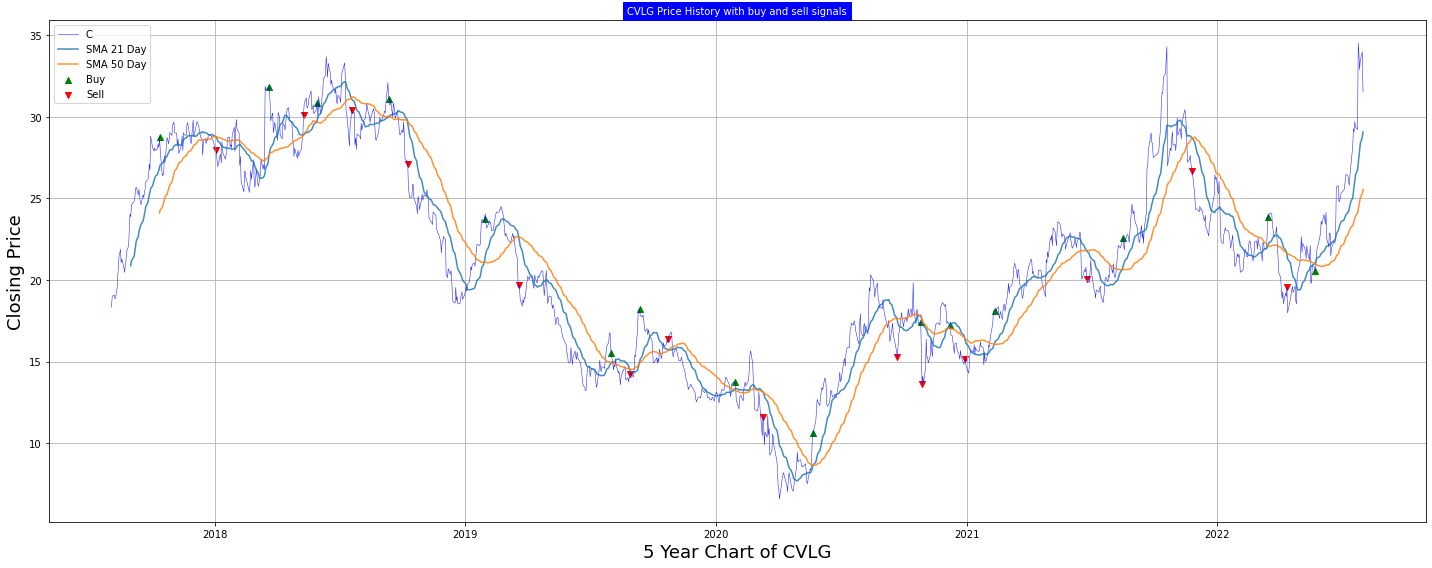

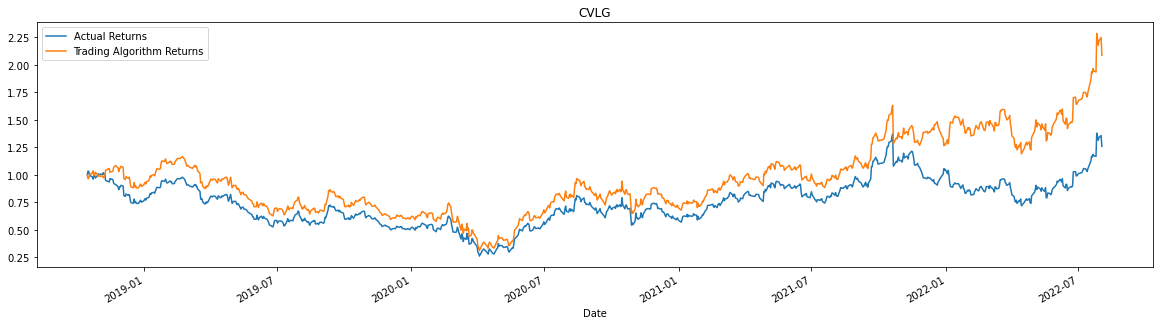

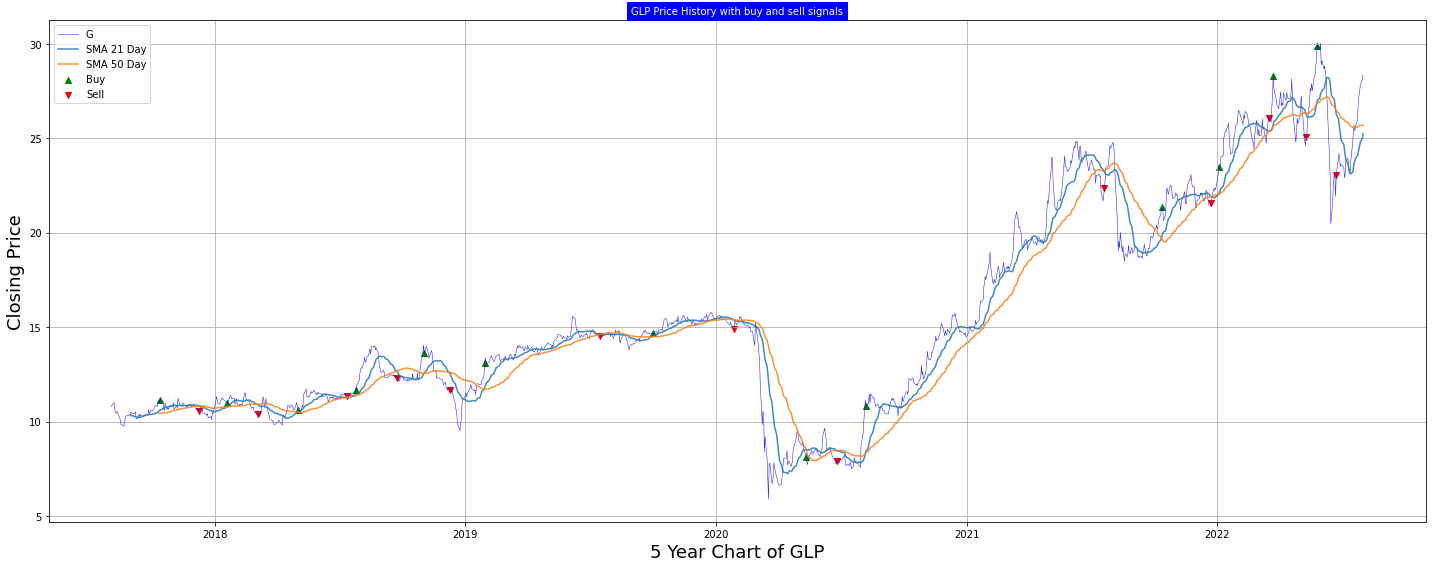

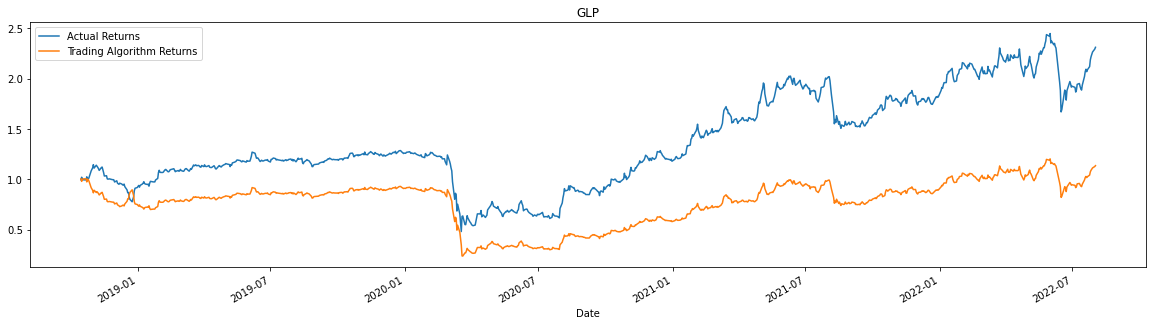

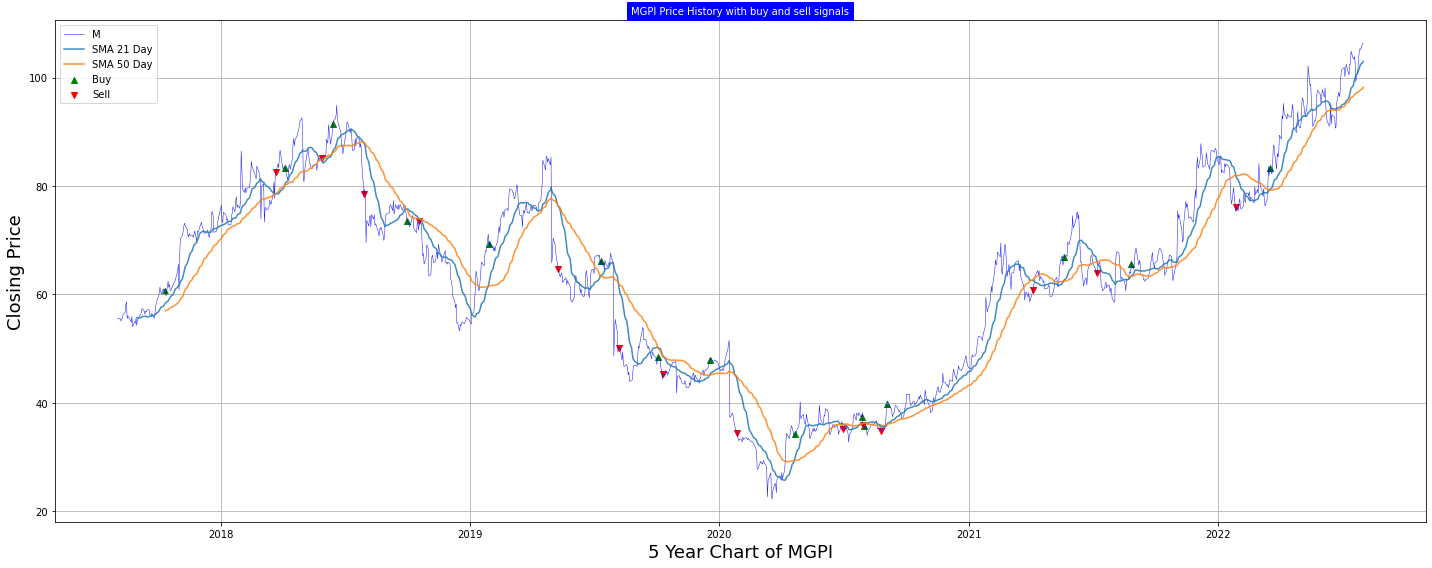

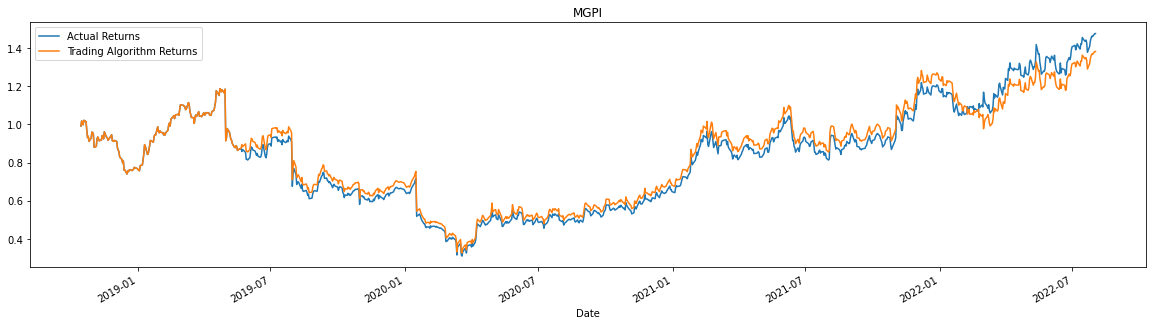

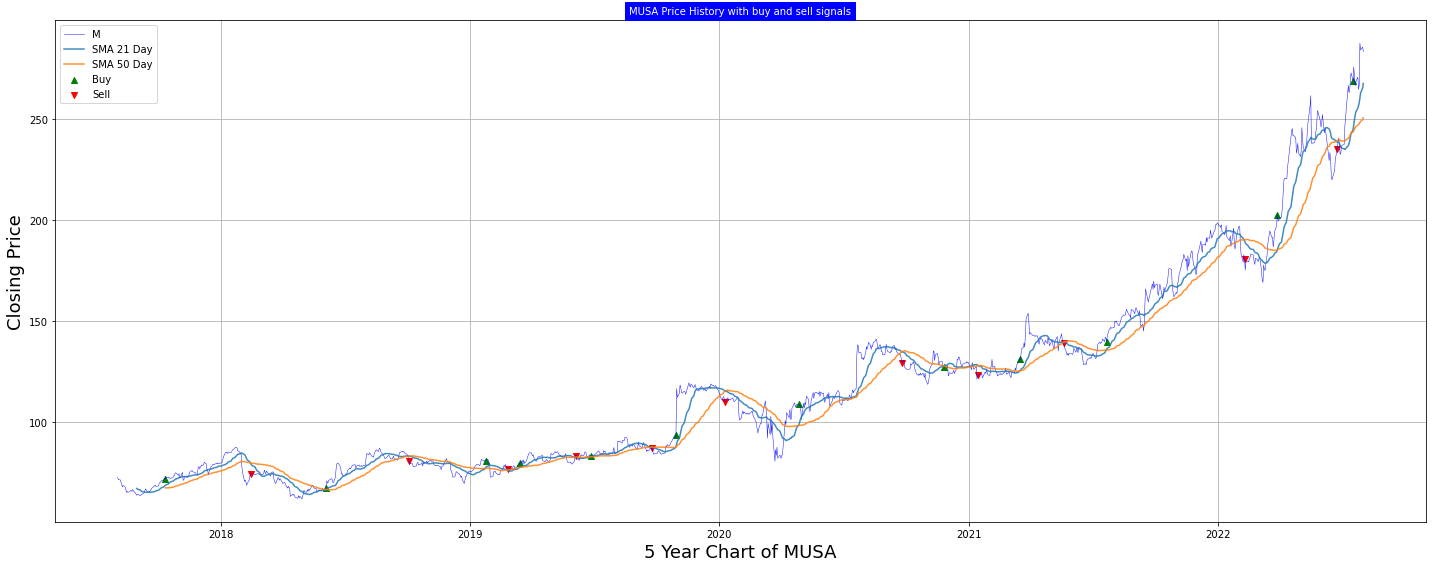

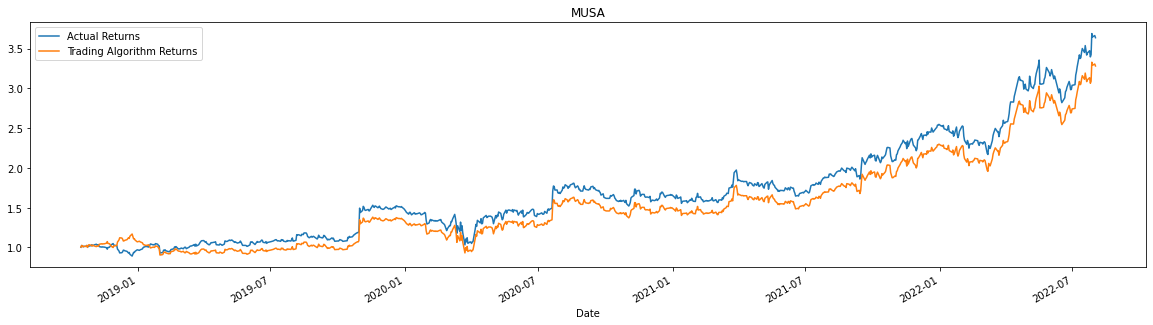

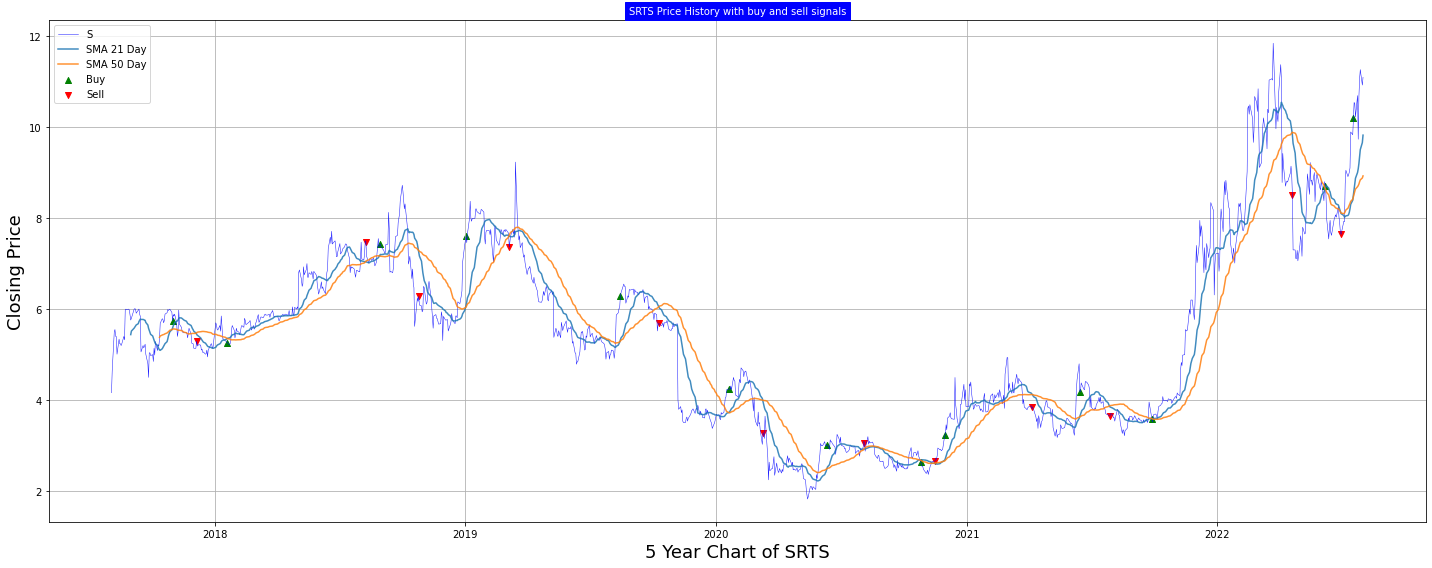

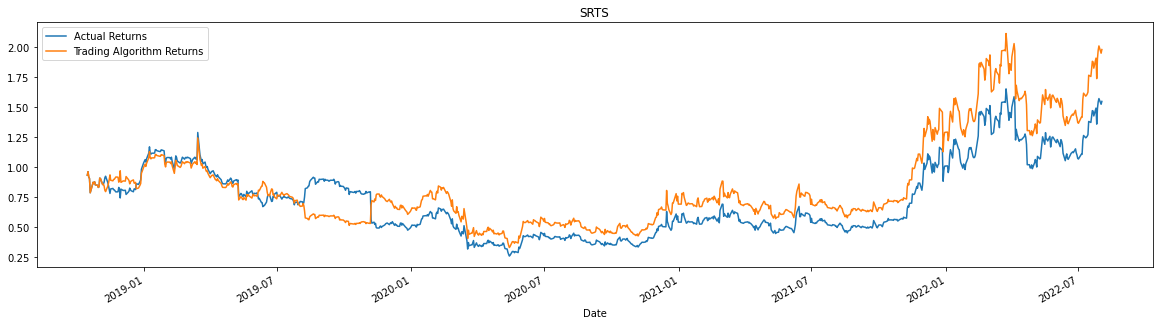

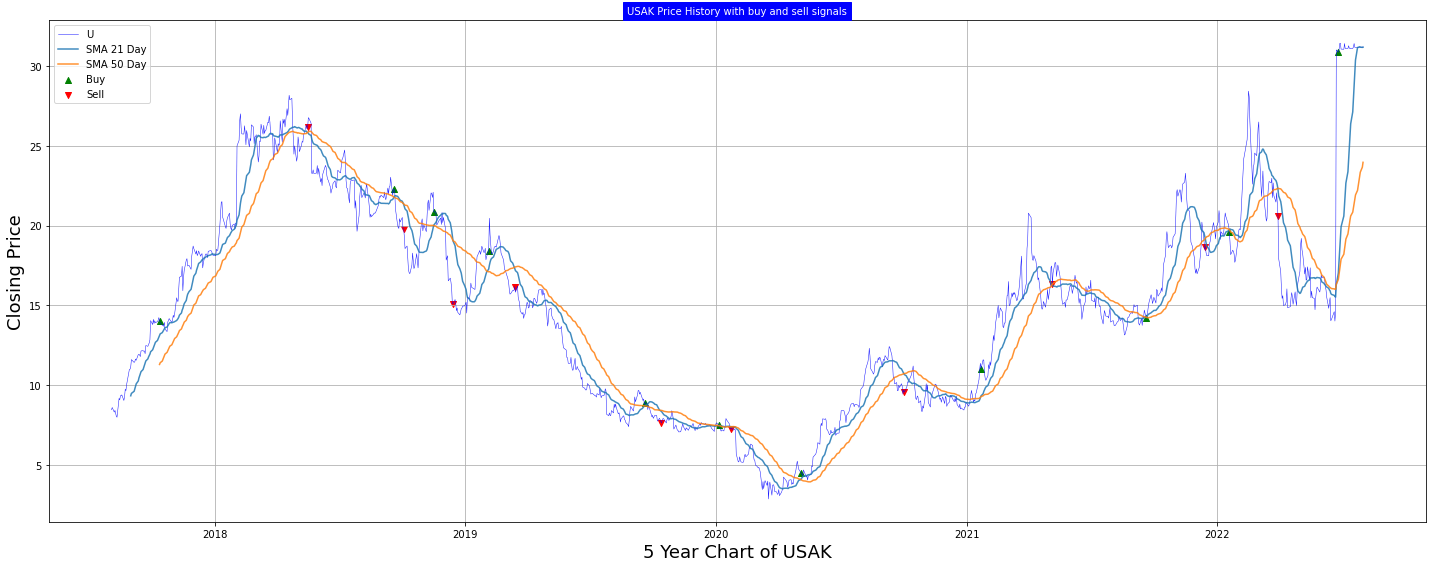

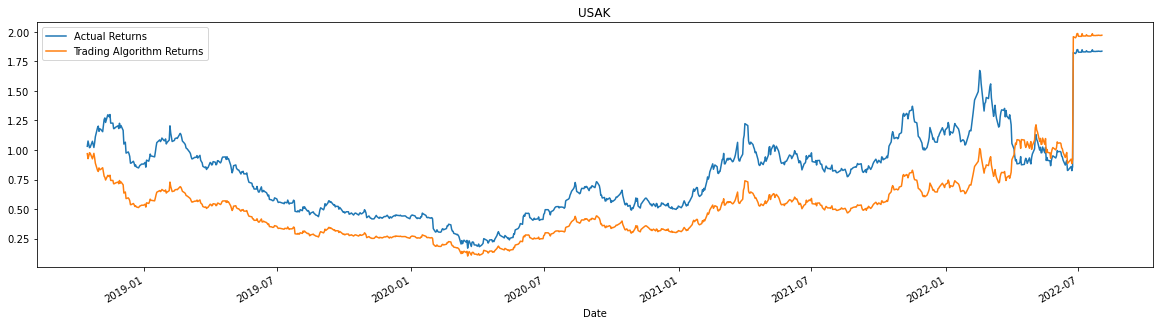

In [9]:
for ticker in ticker:
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(period='5y')
    stock_hist = stock_hist.drop(columns=["Dividends", "Stock Splits", "Open", "High", "Low"])
    stock_hist['Ticker'] = (ticker)
    col = stock_hist.pop('Ticker')
    stock_hist.insert(loc=0, column='Ticker', value=col)
    stock_hist['Actual Returns'] = stock_hist['Close'].pct_change()
    stock_hist.dropna()
    stock_hist["SMA 21 Day"] = TA.SMA(stock_hist['Close'].values, timeperiod=21)
    stock_hist["SMA 50 Day"] = TA.SMA(stock_hist['Close'].values, timeperiod=50)
    stock_hist.dropna()
    stock_hist["Signal"]=0.0
    
    stock_hist.loc[(stock_hist["SMA 21 Day"] > stock_hist["SMA 50 Day"]), "Signal"] = 1.0
    stock_hist.loc[(stock_hist["SMA 21 Day"] < stock_hist["SMA 50 Day"]), "Signal"] = -1.0
        
    stock_hist["Entry/Exit"] = stock_hist["Signal"].diff()
    stock_ticker = stock_hist['Ticker']
    def buy_sell(stock_hist):
        signalBuy = []
        signalSell = []
        position = False 

        for i in range(len(stock_hist)):
            if stock_hist['SMA 21 Day'][i] > stock_hist['SMA 50 Day'][i]:
                if position == False :
                    signalBuy.append(stock_hist['Close'][i])
                    signalSell.append(np.nan)
                    position = True
                else:
                    signalBuy.append(np.nan)
                    signalSell.append(np.nan)
            elif stock_hist['SMA 21 Day'][i] < stock_hist['SMA 50 Day'][i]:
                if position == True:
                    signalBuy.append(np.nan)
                    signalSell.append(stock_hist['Close'][i])
                    position = False
                else:
                    signalBuy.append(np.nan)
                    signalSell.append(np.nan)
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        return pd.Series([signalBuy, signalSell])
    stock_hist['Buy_Signal_price'], stock_hist['Sell_Signal_price'] = buy_sell(stock_hist)
    
    fig, ax = plt.subplots(figsize=(20,8))
    ax.plot(stock_hist['Close'] , label = ticker[0] ,linewidth=0.5, color='blue', alpha = 0.9)
    ax.plot(stock_hist['SMA 21 Day'], label = 'SMA 21 Day', alpha = 0.85)
    ax.plot(stock_hist['SMA 50 Day'], label = 'SMA 50 Day' , alpha = 0.85)
    ax.scatter(stock_hist.index , stock_hist['Buy_Signal_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
    ax.scatter(stock_hist.index , stock_hist['Sell_Signal_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
    ax.set_title(stock_ticker[0] + " Price History with buy and sell signals",fontsize=10, backgroundcolor='blue', color='white')
    ax.set_xlabel(f'5 Year Chart of {stock_ticker[0]}' ,fontsize=18)
    ax.set_ylabel('Closing Price' , fontsize=18)
    legend = ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()




    X= stock_hist[['SMA 21 Day', 'SMA 50 Day']].shift().dropna().copy()
    y = stock_hist["Signal"].copy()
    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=12)
    
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Create testing datasets

    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]
    # Standerdize the data

    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create classification report

    svm_model = svm.SVC()
    svm_model = svm_model.fit(X_train_scaled, y_train)

    training_signal_predictions = svm_model.predict(X_train_scaled)
    training_report = classification_report(y_train, training_signal_predictions, output_dict=True)
    classification_report_dic[ticker] = pd.DataFrame(training_report)
    
    # Backtest the machine learning algorithm
    
    testing_signal_predictions = svm_model.predict(X_test_scaled)
    testing_report = classification_report(y_test, testing_signal_predictions, output_dict=True)
    testing_report_dic[ticker] = pd.DataFrame(testing_report)
    
    # Compare actual and predicted returns

    predictions_df = pd.DataFrame(index=X_test.index)
    predictions_df["Predicted Signal"] = testing_signal_predictions
    predictions_df["Actual Returns"] = stock_hist["Actual Returns"]
    predictions_df["Trading Algorithm Returns"] = (
        stock_hist["Actual Returns"] * predictions_df["Predicted Signal"]
    )

    
    predictions_df_dic[ticker] = pd.DataFrame(predictions_df).head()
    
    (1 + predictions_df[["Actual Returns", "Trading Algorithm Returns"]]).cumprod().plot(title=ticker, figsize = (20,5))
    name = str(ticker)
    all_stock_df[name] = stock_hist


In [10]:
classification_report_dic

{'CVLG':                  -1.0         1.0  accuracy   macro avg  weighted avg
 precision    0.972477    0.979021   0.97619    0.975749       0.97619
 recall       0.972477    0.979021   0.97619    0.975749       0.97619
 f1-score     0.972477    0.979021   0.97619    0.975749       0.97619
 support    109.000000  143.000000   0.97619  252.000000     252.00000,
 'GLP':                 -1.0         1.0  accuracy   macro avg  weighted avg
 precision   0.975904    0.940828  0.952381    0.958366      0.953494
 recall      0.890110    0.987578  0.952381    0.938844      0.952381
 f1-score    0.931034    0.963636  0.952381    0.947335      0.951863
 support    91.000000  161.000000  0.952381  252.000000    252.000000,
 'MGPI':                 -1.0         1.0  accuracy   macro avg  weighted avg
 precision   1.000000    0.890995   0.90873    0.945498      0.918679
 recall      0.640625    1.000000   0.90873    0.820312      0.908730
 f1-score    0.780952    0.942356   0.90873    0.861654     

In [11]:
testing_report_dic

{'CVLG':                  -1.0         1.0  accuracy   macro avg  weighted avg
 precision    1.000000    0.494432  0.525105    0.747216      0.765196
 recall       0.113281    1.000000  0.525105    0.556641      0.525105
 f1-score     0.203509    0.661699  0.525105    0.432604      0.416308
 support    512.000000  444.000000  0.525105  956.000000    956.000000,
 'GLP':                  -1.0         1.0  accuracy   macro avg  weighted avg
 precision    0.924528    0.709856  0.721757    0.817192      0.779692
 recall       0.157556    0.993798  0.721757    0.575677      0.721757
 f1-score     0.269231    0.828165  0.721757    0.548698      0.646336
 support    311.000000  645.000000  0.721757  956.000000    956.000000,
 'MGPI':                  -1.0         1.0  accuracy   macro avg  weighted avg
 precision    1.000000    0.613808  0.625523    0.806904      0.770143
 recall       0.074935    1.000000  0.625523    0.537468      0.625523
 f1-score     0.139423    0.760695  0.625523    0.45

In [12]:
predictions_df_dic

{'CVLG':             Predicted Signal  Actual Returns  Trading Algorithm Returns
 Date                                                                   
 2018-10-15              -1.0        0.001590                  -0.001590
 2018-10-16              -1.0        0.032540                  -0.032540
 2018-10-17              -1.0       -0.002306                   0.002306
 2018-10-18              -1.0       -0.031587                   0.031587
 2018-10-19              -1.0       -0.005171                   0.005171,
 'GLP':             Predicted Signal  Actual Returns  Trading Algorithm Returns
 Date                                                                   
 2018-10-15              -1.0       -0.004950                   0.004950
 2018-10-16              -1.0        0.025428                  -0.025428
 2018-10-17              -1.0       -0.018868                   0.018868
 2018-10-18              -1.0       -0.004945                   0.004945
 2018-10-19              -1.0      

In [13]:
all_stock_df['MGPI']

Ticker       Close  Volume  Actual Returns  SMA 21 Day  SMA 50 Day  \
Date                                                                            
2017-08-03   MGPI   55.461868  347100             NaN         NaN         NaN   
2017-08-04   MGPI   55.585537  146300        0.002230         NaN         NaN   
2017-08-07   MGPI   55.518940  137800       -0.001198         NaN         NaN   
2017-08-08   MGPI   55.081326   91300       -0.007882         NaN         NaN   
2017-08-09   MGPI   55.471386   74400        0.007082         NaN         NaN   
...           ...         ...     ...             ...         ...         ...   
2022-07-27   MGPI  104.629997   96800        0.011309  101.654286   97.481841   
2022-07-28   MGPI  105.339996   95400        0.006786  102.075714   97.618918   
2022-07-29   MGPI  105.180000  102200       -0.001519  102.446667   97.748001   
2022-08-01   MGPI  106.320000  109500        0.010839  102.743334   97.965800   
2022-08-02   MGPI  106.349998  110629        0.000282  102.981429   98.217600   

            Signal  Entry/Exit  Buy_Signal_price  Sell_Signal_price  
Date                                                                 
2017-08-03     0.0         NaN               NaN                NaN  
2017-08-04     0.0         0.0               NaN                NaN  
2017-08-07     0.0         0.0               NaN                NaN  
2017-08-08     0.0         0.0               NaN                NaN  
2017-08-09     0.0         0.0               NaN                NaN  
...            ...         ...               ...                ...  
2022-07-27     1.0         0.0               NaN                NaN  
2022-07-28     1.0         0.0               NaN                NaN  
2022-07-29     1.0         0.0               NaN                NaN  
2022-08-01     1.0         0.0               NaN                NaN  
2022-08-02     1.0         0.0               NaN                NaN  

[1258 rows x 10 columns]

In [14]:
entry = stock_hist[stock_hist["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
    )


exit = stock_hist[stock_hist["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
    )


security_close = stock_hist[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
    )


moving_avgs = stock_hist[["SMA 21 Day", "SMA 50 Day"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
    )


entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot
    

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)